# 一、数据预处理


# 1.1 环境准备 

In [ ]:
!pip install -U openmim
!mim install mmengine

In [ ]:
! mim uninstall mmcv
! mim uninstall mmcv-full

In [ ]:
!mim install 'mmcv>=2.0.0rc4'

In [ ]:
!pip install opencv-python pillow matplotlib seaborn tqdm 'mmdet>=3.0.0rc1' -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
# 删掉原有的 mmtracking 文件夹（如有）
# !rm -rf mmsegmentation
# 从 github 上下载最新的 mmsegmentation 源代码
# !git clone https://github.com/open-mmlab/mmsegmentation.git -b dev-1.x

In [ ]:
# 进入主目录
import os
os.chdir('mmsegmentation')

In [ ]:
!pip install -v -e .

In [ ]:
# 检查 Pytorch
import torch, torchvision
print('Pytorch 版本', torch.__version__)
print('CUDA 是否可用',torch.cuda.is_available())

In [ ]:
# 检查 mmcv
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('MMCV版本', mmcv.__version__)
print('CUDA版本', get_compiling_cuda_version())
print('编译器版本', get_compiler_version())

In [ ]:
# 检查 mmsegmentation
import mmseg
from mmseg.utils import register_all_modules
from mmseg.apis import inference_model, init_model
print('mmsegmentation版本', mmseg.__version__)

## 1.2 import

In [ ]:
import os
import numpy as np
from PIL import Image
import os.path as osp
from tqdm import tqdm
import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

## 1.3 下载数据

In [ ]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

## 1.4 样本转换

In [ ]:
# 数据集图片和标注路径
data_root = '/openbayes/home/clothing-co-parsing'
img_dir = 'photos'
ann_dir = 'annotations/pixel-level'
classes = ('背景(null)','配件(accessories)','包(bag)','腰带(belt)','运动上衣(blazer)','女衬衫(blouse)','紧身衣(bodysuit)','长筒靴(boots)','胸罩(bra)','手镯(bracelet)','斗篷(cape)','开襟毛衣(cardigan)','木屐(clogs)','外套(coat)','晚礼服(dress)','耳环(earrings)','平底鞋(flats)','眼镜(glasses)','手套(gloves)','头发(hair)','帽子(hat)','高跟鞋(heels)','帽衫(hoodie)','内衣(intimate)','夹克(jacket)','牛仔裤(jeans)','无袖套衫(jumper)','打底裤(leggings)','平底便鞋(loafers)','项链(necklace)','内裤(panties)','裤子(pants)','帆布鞋(pumps)','小提包(purse)','戒指(ring)','连衣裤(romper)','凉鞋(sandals)','围巾(scarf)','衬衫(shirt)','鞋子(shoes)','短裤(shorts)','皮肤(skin)','裙子(skirt)','运动鞋(sneakers)','袜子(socks)','长筒袜(stockings)','西装(suit)','太阳镜(sunglasses)','毛衣(sweater)','运动衫(sweatshirt)','游泳衣(swimwear)','T恤(t-shirt)','领带(tie)','紧身衣(tights)','上衣(top)','背心(vest)','钱包(wallet)','手表(watch)','坡跟鞋(wedges)')
palette = [[0,0,0],[139,0,0],[244,164,96],[165,42,42],[255,245,238],[255,250,240],[143,188,143],[255,240,245],[255,20,147],[255,255,255],[255,228,181],[219,112,147],[148,0,211],[128,0,0],[0,0,255],[205,92,92],[169,169,169],[123,104,238],[0,250,154],[0,128,128],[192,192,192],[222,184,135],[46,139,87],[100,149,237],[186,85,211],[175,238,238],[199,21,133],[0,0,205],[255,255,224],[160,82,45],[138,43,226],[152,251,152],[176,224,230],[210,105,30],[220,20,60],[240,128,128],[60,179,113],[255,250,205],[0,128,0],[255,165,0],[255,228,196],[255,239,213],[233,150,122],[245,245,220],[176,196,222],[85,107,47],[240,255,240],[34,139,34],[255,228,225],[245,255,250],[30,144,255],[75,0,130],[221,160,221],[0,255,255],[250,240,230],[211,211,211],[188,143,143],[238,232,170],[127,255,170]]

In [ ]:
for file in tqdm(mmengine.scandir(osp.join(data_root, ann_dir), suffix='.mat')):
    mat=loadmat(os.path.join(data_root,ann_dir,file))
    seg_map = mat['groundtruth'].astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.mat', '.png')))
    

## 1.5 样本验证

In [ ]:
import matplotlib.patches as mpatches

image_name = '0207'
img_origin = Image.open(os.path.join(data_root,img_dir,image_name+'.jpg'))
img_seg = Image.open(os.path.join(data_root,ann_dir,image_name+'.png'))

figure = plt.figure(figsize=(8, 6))
ax = figure.add_subplot(1, 2, 1)
ax.imshow(np.array(img_origin.convert('RGB')))
ax = figure.add_subplot(1, 2, 2)
ax.imshow(np.array(img_seg.convert('RGB')))

mat=loadmat(os.path.join(data_root,ann_dir,image_name+'.mat'))
seg_map = mat['groundtruth'].astype(np.uint8)
type_set = set()
for i in seg_map:
    for j in i:
        type_set.add(int(j))
# 图例小块
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in type_set]
# 图例
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

## 1.6 划分测试集合验证集

In [ ]:
# 随机划分训练集和验证集
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

# 二、训练模型

## 2.1 修改数据集类

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

## 2.2 修改config配置文件

In [ ]:
# 下载 config 文件 和 预训练模型checkpoint权重文件
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [ ]:
from mmengine import Config
cfg = Config.fromfile('/openbayes/home/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
#cfg.model.pretrained = '/openbayes/home/resnetv1c50_8xb32_in1k_20220214-3343eccd.pth'
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.num_classes = 59
# cfg.model.decode_head=dict(
#     type='DepthwiseSeparableASPPHead',
#     in_channels=2048,
#     in_index=3,
#     channels=512,
#     dilations=(1, 12, 24, 36),
#     c1_in_channels=256,
#     c1_channels=48,
#     dropout_ratio=0.1,
#     num_classes=59,
#     norm_cfg=dict(type='SyncBN', requires_grad=True),
#     align_corners=False,
#     loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)
# )

cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.num_classes = 59

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=(256,256), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.batch_size = 8
cfg.train_dataloader.num_workers = 4
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = '/openbayes/home/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/clothing'

# 训练迭代次数
cfg.train_cfg.max_iters = 5000
# 评估模型间隔
cfg.train_cfg.val_interval = 5000
# 日志记录间隔
cfg.default_hooks.logger.interval = 500
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 5000

# # 随机数种子
cfg['randomness'] = dict(seed=0)

## 2.3 执行训练

In [ ]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

In [7]:
runner.train()

02/12 13:40:54 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:54 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:54 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:55 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:55 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:55 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:

/usr/local/lib/python3.8/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


02/12 13:40:56 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 13:40:56 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
02/12 13:40:56 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
02/12 13:40:56 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: /openbayes/home/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([59, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

# 三、验证模型

In [8]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [43]:
# 初始化模型
checkpoint_path = '/openbayes/home/work_dirs/clothing/iter_5000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: /openbayes/home/work_dirs/clothing/iter_5000.pth


In [48]:
# 载入测试图像
# img_path = '/openbayes/home/clothing-co-parsing/photos/0207.jpg'
img_path = '/openbayes/home/周杰伦.png'

img = mmcv.imread(img_path)


In [49]:
# 预测
result = inference_model(model, img)

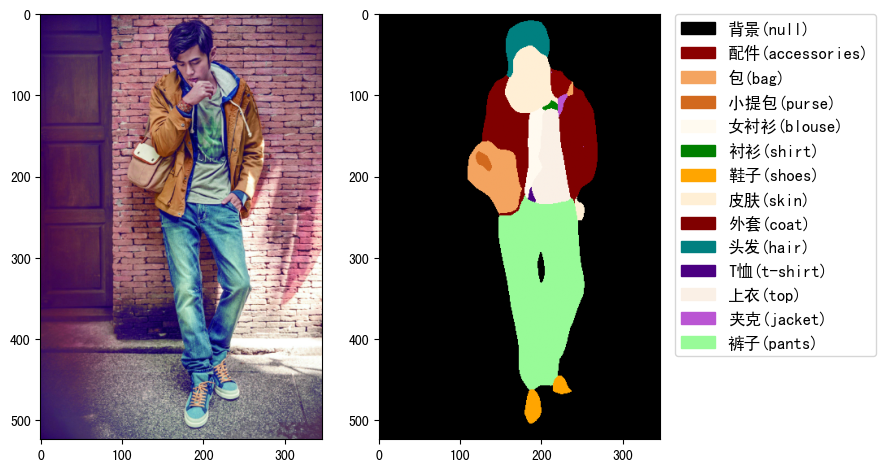

In [50]:
import matplotlib.patches as mpatches

# 可视化预测结果
opacity = 0 # 透明度，越大越接近原图
class_map = result.pred_sem_seg.data[0].detach().cpu().numpy()
seg_map = class_map.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))
visualization = show_result_pyplot(model, img, result, opacity=1.0, title='MMSeg', out_file='outputs/周杰伦.jpg')
img_origin = Image.open(img_path)

figure = plt.figure(figsize=(8, 6))
ax = figure.add_subplot(1, 2, 1)
ax.imshow(np.array(img_origin.convert('RGB')))
ax = figure.add_subplot(1, 2, 2)
ax.imshow(((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255)

# 图例
data = result.pred_sem_seg.data[0]
type_set = set()
dim0, dim1 = data.shape
for i in range(dim0):
    for j in range(dim1):
        typee = data[i][j].item()
        type_set.add(int(typee))
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in type_set]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()